In [16]:
import os
os.environ['OMP_NUM_THREADS'] = '1' 
import warnings
warnings.filterwarnings("ignore")

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load data
customers = pd.read_csv("C:/Users/danis/Downloads/Customers.csv")
transactions = pd.read_csv("C:/Users/danis/Downloads/Transactions.csv")

In [22]:
# Merge datasets and aggregate transaction data
data = pd.merge(customers,
                transactions.groupby('CustomerID').agg(
                    total_spent=('TotalValue', 'sum'),
                    total_transactions=('TransactionID', 'count'),
                    avg_transaction_value=('TotalValue', 'mean'),
                    recency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days)
                ).reset_index(),
                on='CustomerID', how='left').fillna(0)

data

,CustomerID,CustomerName,Region,SignupDate,total_spent,total_transactions,avg_transaction_value,recency
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,670.904000,89.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,465.685000,58.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,681.345000,158.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,669.360000,38.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,678.080000,87.0
...,...,...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,4982.88,4.0,1245.720000,46.0
196,C0197,Christina Harvey,Europe,2023-03-21,1928.65,3.0,642.883333,33.0
197,C0198,Rebecca Ray,Europe,2022-02-27,931.83,2.0,465.915000,117.0
198,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,4.0,494.820000,96.0


In [24]:
# Define the features for clustering
data['Region'] = LabelEncoder().fit_transform(data['Region'])
features = StandardScaler().fit_transform(data[['Region', 'total_spent', 'total_transactions']])

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [26]:
# Determine optimal number of clusters using DB Index
optimal_k, db_indexes = 2, []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(features)
    db_indexes.append(davies_bouldin_score(features, kmeans.labels_))
    if db_indexes[-1] == min(db_indexes):
        optimal_k = k

optimal_k

6

In [28]:
# Apply KMeans with the optimal number of clusters
data['Cluster'] = KMeans(n_clusters=optimal_k, random_state=42).fit_predict(features)

data

,CustomerID,CustomerName,Region,SignupDate,total_spent,total_transactions,avg_transaction_value,recency,Cluster
0,C0001,Lawrence Carroll,3,2022-07-10,3354.52,5.0,670.904000,89.0,1
1,C0002,Elizabeth Lutz,0,2022-02-13,1862.74,4.0,465.685000,58.0,4
2,C0003,Michael Rivera,3,2024-03-07,2725.38,4.0,681.345000,158.0,1
3,C0004,Kathleen Rodriguez,3,2022-10-09,5354.88,8.0,669.360000,38.0,3
4,C0005,Laura Weber,0,2022-08-15,2034.24,3.0,678.080000,87.0,4
...,...,...,...,...,...,...,...,...,...
195,C0196,Laura Watts,1,2022-06-07,4982.88,4.0,1245.720000,46.0,4
196,C0197,Christina Harvey,1,2023-03-21,1928.65,3.0,642.883333,33.0,4
197,C0198,Rebecca Ray,1,2022-02-27,931.83,2.0,465.915000,117.0,2
198,C0199,Andrea Jenkins,1,2022-12-03,1979.28,4.0,494.820000,96.0,4


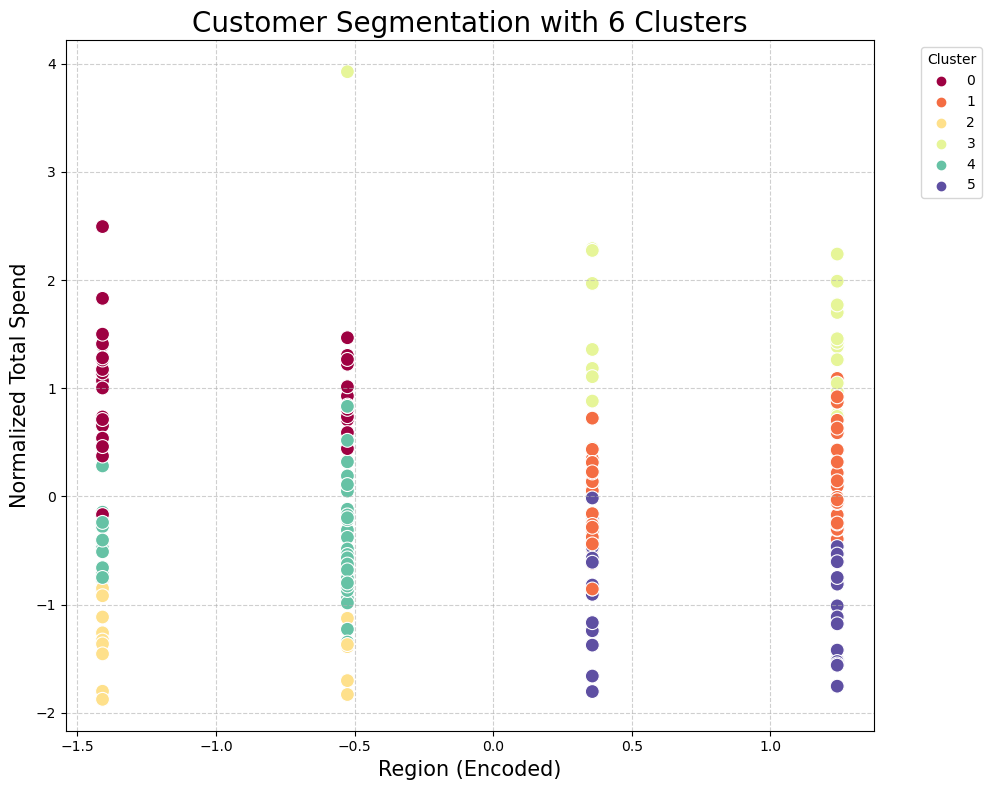

In [30]:
# Enhanced visualization for customer segmentation
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=features[:, 0], y=features[:, 1], hue=data['Cluster'], palette="Spectral", s=100, edgecolor="white"
)
plt.title(f"Customer Segmentation with {optimal_k} Clusters", fontsize=20)
plt.xlabel("Region (Encoded)", fontsize=15)
plt.ylabel("Normalized Total Spend", fontsize=15)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [32]:
optimal_k = 6

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Evaluate the clustering results
db_index = davies_bouldin_score(features_scaled, data['Cluster'])
silhouette = silhouette_score(features_scaled, data['Cluster'])

print(db_index)
print(silhouette)

0.9149390467175039
0.3369642353629596


In [34]:

# Dimensionality reduction using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)

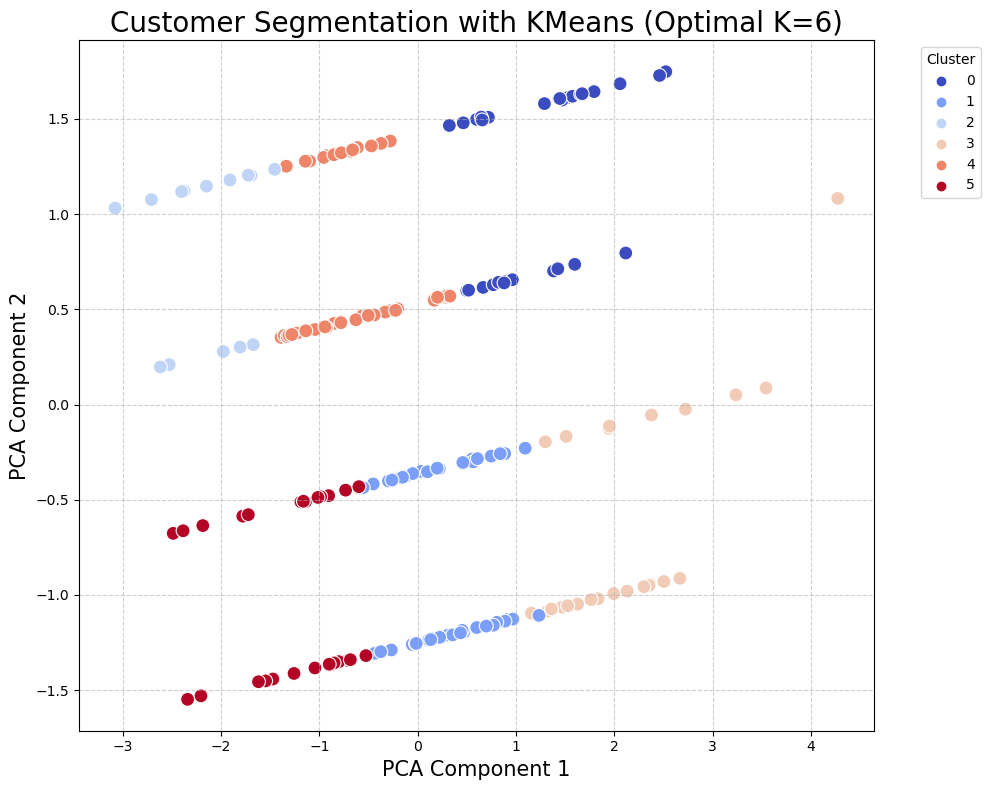

In [36]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=data['Cluster'], palette="coolwarm", s=100, edgecolor="white")
plt.title(f"Customer Segmentation with KMeans (Optimal K={optimal_k})", fontsize=20)
plt.xlabel("PCA Component 1", fontsize=15)
plt.ylabel("PCA Component 2", fontsize=15)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [40]:
# Output results
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

Optimal Number of Clusters: 6
Davies-Bouldin Index: 0.91
Silhouette Score: 0.34
